In [1]:
import os
import time
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from collections import deque
%matplotlib inline

C:\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
#####Data Import 
#This step is to icorporate movie ID into the original data 
#Reference: https://www.kaggle.com/morrisb/how-to-recommend-anything-deep-recommender
#laod the user data
# Load single data-file
dfuser = pd.read_csv('combined_data_1.txt', header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])
# Find empty rows to slice dataframe for each movie
tmpmovies = dfuser[dfuser['Rating'].isna()]['User'].reset_index()
movieindice = [[index, int(movie[:-1])] for index, movie in tmpmovies.values]
# Shift the movie_indices by one to get start and endpoints of all movies
shifted = deque(movieindice)
shifted.rotate(-1)
# Gather all dataframes
user_data = []
# Iterate over all movies
for [df_id_1, movieid], [df_id_2, nextmovieid] in zip(movieindice, shifted): 
    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        tmp_df = dfuser.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = dfuser.loc[df_id_1+1:].copy()  
    # Create movie_id column
    tmp_df['Movie'] = movieid
    # Append dataframe to list
    user_data.append(tmp_df)
# Combine all dataframes
newdf = pd.concat(user_data)
del user_data, dfuser, tmpmovies, tmp_df, shifted, movieindice, df_id_1, movieid, df_id_2, nextmovieid
print('Shape User-Ratings:\t{}'.format(newdf.shape))
newdf.sample(5)

Shape User-Ratings:	(24053764, 4)


,User,Rating,Date,Movie
6416532,1715565,5.0,2004-09-25,1255
22239040,2568959,3.0,2005-07-01,4216
6278485,737833,5.0,2004-11-29,1220
15183479,1121411,3.0,2005-06-20,2913
20983002,2257854,5.0,2005-10-10,3938


In [3]:
ratings=newdf

In [4]:
df_title = pd.read_csv('titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title=df_title.drop(columns=['Year'])
df_title=df_title.dropna()
df_title.head()

,Movie_Id,Name
0,1,Dinosaur Planet
1,2,Isle of Man TT 2004 Review
2,3,Character
3,4,Paula Abdul's Get Up & Dance
4,5,The Rise and Fall of ECW


In [5]:
print(ratings.head())
print(df_title.head())

      User  Rating        Date  Movie
1  1488844     3.0  2005-09-06      1
2   822109     5.0  2005-05-13      1
3   885013     4.0  2005-10-19      1
4    30878     4.0  2005-12-26      1
5   823519     3.0  2004-05-03      1
   Movie_Id                          Name
0         1               Dinosaur Planet
1         2    Isle of Man TT 2004 Review
2         3                     Character
3         4  Paula Abdul's Get Up & Dance
4         5      The Rise and Fall of ECW


In [6]:
num_users = len(ratings.User.unique())
num_items = len(ratings.Movie.unique())
print('Number of Unique Users:', num_users)
print('Number of Unique Movies', num_items)

Number of Unique Users: 470758
Number of Unique Movies 4499


In [7]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(ratings.groupby('Rating').size(), columns=['count'])
print(df_ratings_cnt_tmp)
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - ratings.shape[0]
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
print(df_ratings_cnt)
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
print(df_ratings_cnt)

          count
Rating         
1.0     1118186
2.0     2439073
3.0     6904181
4.0     8085741
5.0     5506583
          count
0.0  2093886478
1.0     1118186
2.0     2439073
3.0     6904181
4.0     8085741
5.0     5506583
          count  log_count
0.0  2093886478  21.462288
1.0     1118186  13.927218
2.0     2439073  14.707129
3.0     6904181  15.747638
4.0     8085741  15.905613
5.0     5506583  15.521455


Text(0.5,1,'Score Counts')

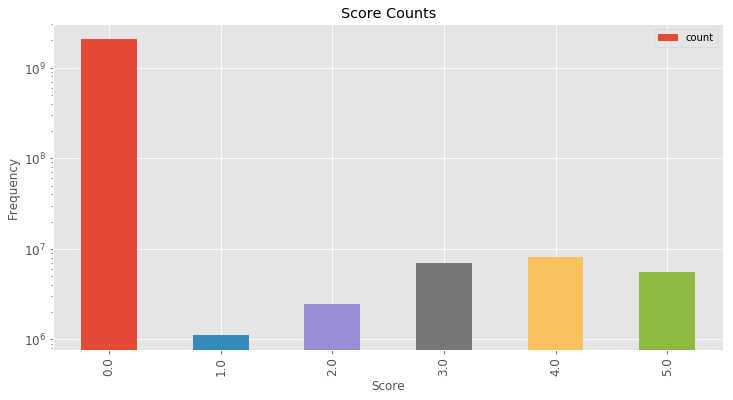

In [12]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 6),
    logy=True,
    fontsize=12,
)
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")
ax.set_title("Score Counts")

       count
Movie       
1        547
2        145
3       2012
4        142
5       1140


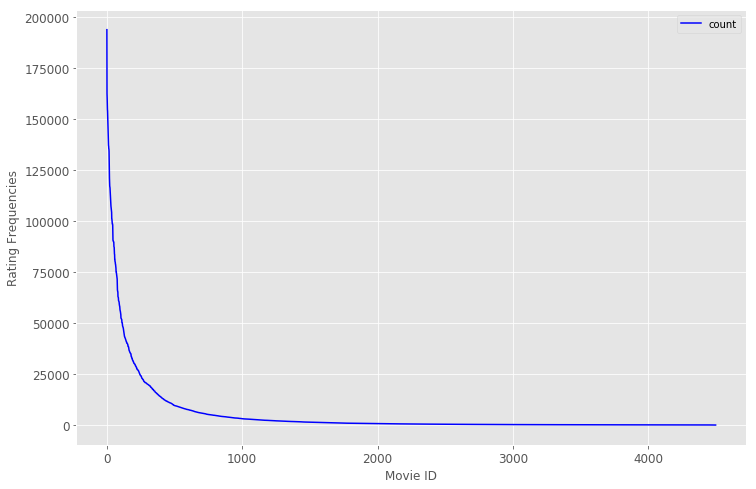

In [13]:
# get rating frequency
df_movies_cnt = pd.DataFrame(ratings.groupby('Movie').size(), columns=['count'])
print(df_movies_cnt.head())
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(figsize=(12, 8),fontsize=12,color='Blue'
    )
ax.set_xlabel("Movie ID")
ax.set_ylabel("Rating Frequencies")
ax.set_title=("Rating Frequency of Movies")

In [14]:
df_movies_cnt['count'].quantile(np.arange(1, 0.5, -0.1))
# Show shapes of the data rating through counting 
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = ratings[ratings.Movie.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (24053764, 4)
shape of ratings data after dropping unpopular movies:  (24053422, 4)


         count
User          
10          49
1000004      1
1000027     30
1000033    101
1000035     20


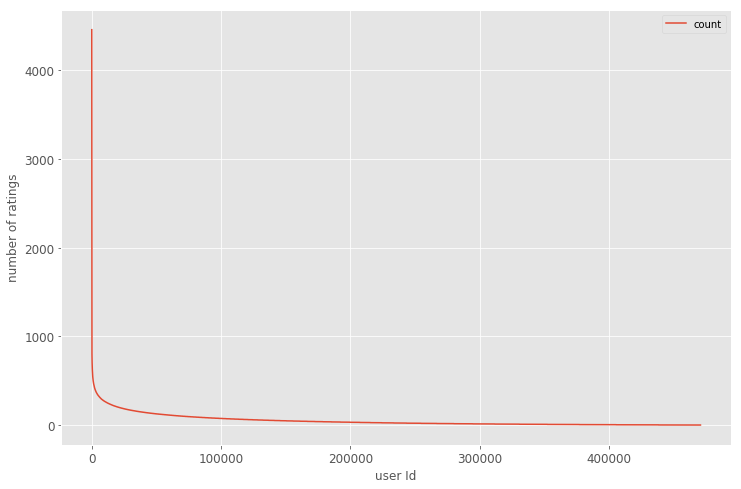

In [15]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('User').size(), columns=['count'])
print(df_users_cnt.head())# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")
ax.set_title=("Rating Frequency of All Users")

In [16]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    4459.0
0.95     190.0
0.90     132.0
0.85     100.0
0.80      79.0
0.75      64.0
0.70      52.0
0.65      43.0
0.60      36.0
0.55      29.0
Name: count, dtype: float64

In [17]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.User.isin(active_users)]
print('original rating: ', ratings.shape)
print('after dropping inactive users: ', df_ratings_drop_users.shape)
# pivot 
movie_user_mat = df_ratings_drop_users.pivot(index='Movie', columns='User', values='Rating').fillna(0)
# movie title indexer
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_title.set_index('Movie_Id').loc[movie_user_mat.index].Name))
}
# sparse matrix 
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)
print(movie_user_mat_sparse)

original rating:  (24053764, 4)
after dropping inactive users:  (18687764, 4)
  (0, 118)	4.0
  (0, 544)	4.0
  (0, 590)	1.0
  (0, 740)	4.0
  (0, 1344)	5.0
  (0, 2039)	3.0
  (0, 2832)	3.0
  (0, 3676)	3.0
  (0, 4034)	4.0
  (0, 4490)	3.0
  (0, 4790)	4.0
  (0, 4933)	3.0
  (0, 5315)	3.0
  (0, 6225)	1.0
  (0, 6645)	1.0
  (0, 6650)	5.0
  (0, 6982)	3.0
  (0, 7166)	1.0
  (0, 7167)	5.0
  (0, 7234)	4.0
  (0, 7776)	5.0
  (0, 7797)	3.0
  (0, 8282)	4.0
  (0, 8313)	3.0
  (0, 8523)	4.0
  :	:
  (4490, 137224)	3.0
  (4490, 137245)	2.0
  (4490, 137384)	3.0
  (4490, 139126)	3.0
  (4490, 140039)	4.0
  (4490, 140545)	5.0
  (4490, 140682)	3.0
  (4490, 140980)	3.0
  (4490, 141476)	1.0
  (4490, 141708)	2.0
  (4490, 142215)	2.0
  (4490, 143180)	3.0
  (4490, 144149)	4.0
  (4490, 144240)	3.0
  (4490, 144301)	1.0
  (4490, 144578)	3.0
  (4490, 144720)	4.0
  (4490, 146008)	5.0
  (4490, 146246)	2.0
  (4490, 146479)	1.0
  (4490, 147031)	2.0
  (4490, 147198)	2.0
  (4490, 147291)	2.0
  (4490, 147384)	3.0
  (4490, 147650)

In [33]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

In [25]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('No match!')
        return
    if verbose:
        print('Those are your matches: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('Input your favorate Movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Those are your recommendations')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, the distance is {2}'.format(i+1, reverse_mapper[idx], dist))

In [39]:
my_favorite = 'Ed Wood'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

Input your favorate Movie: Ed Wood
Those are your matches: ['Ed Wood', 'Be Good', 'Naked World']

Those are your recommendations
......

Recommendations for Ed Wood:
1: Bowling for Columbine, the distance is 0.6204010804519049
2: Clerks, the distance is 0.6069289311861509
3: Heathers, the distance is 0.6059585885510961
4: High Fidelity, the distance is 0.6049194832721323
5: Fear and Loathing in Las Vegas, the distance is 0.6042655983991281
6: American Beauty, the distance is 0.5978364190026189
7: Eternal Sunshine of the Spotless Mind, the distance is 0.5944012090757069
8: Reservoir Dogs, the distance is 0.5877564869249745
9: Being John Malkovich, the distance is 0.5437149190780948
10: This Is Spinal Tap, the distance is 0.5426127504323175


In [35]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 97.19% of ratings in our data is missing
